In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [102]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [103]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        indices = torch.arange(1, num_params + 1, dtype=torch.float32)  # Create an index tensor from 1 to num_params

        if num_params == 4:
            self.h = 9.9894 * torch.exp(-0.578 * indices)
            self.d = 12.405 * torch.exp(-0.695 * indices)
            self.T = 13.019 * torch.exp(-0.771 * indices)
        elif num_params == 8:
            self.h = -2.043 * torch.log(indices) + 4.235
            self.d = -2.173 * torch.log(indices) + 4.3708
            self.T = -3.959 * torch.log(indices) + 4.6739
        elif num_params == 12:
            self.h = -2.687 * torch.log(indices) + 5.9306
            self.d = -2.869 * torch.log(indices) + 6.1815
            self.T = -3.153 * torch.log(indices) + 5.7195
        elif num_params == 16:
            self.h = -0.018 * (indices ** 2) + 0.2526 * indices + 0.3753
            self.d = -0.0284 * (indices ** 2) + 0.3955 * indices + 0.0063
            self.T = -0.021 * (indices ** 2) + 0.1795 * indices + 0.0105

        self.h = nn.Parameter(self.h)
        self.d = nn.Parameter(self.d)
        self.T = nn.Parameter(self.T)

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Swish

K=4

Epoch 1/20000, Loss: 0.08764089643955231
Epoch 1001/20000, Loss: 0.03962509706616402
Epoch 2001/20000, Loss: 0.03903878107666969
Epoch 3001/20000, Loss: 0.03882927820086479
Epoch 4001/20000, Loss: 0.03879667818546295
Epoch 5001/20000, Loss: 0.038795895874500275
Epoch 6001/20000, Loss: 0.03879630193114281
Epoch 7001/20000, Loss: 0.03879614919424057
Epoch 8001/20000, Loss: 0.03879788890480995
Epoch 9001/20000, Loss: 0.03879673406481743
Epoch 10001/20000, Loss: 0.03879610821604729
Epoch 11001/20000, Loss: 0.038796860724687576
Epoch 12001/20000, Loss: 0.038796566426754
Epoch 13001/20000, Loss: 0.03879573568701744
Epoch 14001/20000, Loss: 0.038796499371528625
Epoch 15001/20000, Loss: 0.03879675269126892
Epoch 16001/20000, Loss: 0.03879612684249878
Epoch 17001/20000, Loss: 0.03879664093255997
Epoch 18001/20000, Loss: 0.03879481554031372
Epoch 19001/20000, Loss: 0.03879609331488609
Loss values: [0.08764089643955231, 0.0431482195854187, 0.04012162610888481, 0.039903488010168076, 0.039767861366

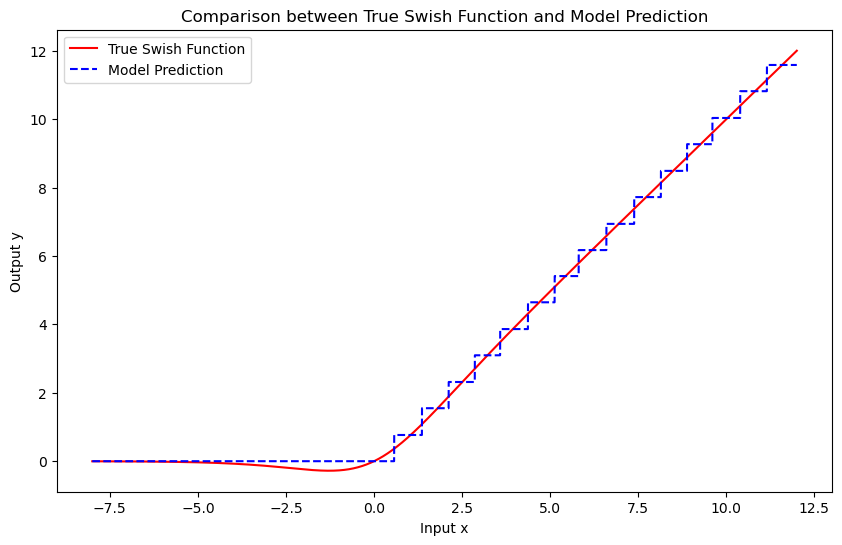

In [104]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -2, steps=20000),
#     torch.linspace(-2, 2, steps=60000),
#     torch.linspace(2, 12, steps=20000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

Epoch 1/20000, Loss: 3.83894681930542
Epoch 1001/20000, Loss: 0.20591144263744354
Epoch 2001/20000, Loss: 0.08109000325202942
Epoch 3001/20000, Loss: 0.04680057615041733
Epoch 4001/20000, Loss: 0.03645915165543556
Epoch 5001/20000, Loss: 0.031037406995892525
Epoch 6001/20000, Loss: 0.026269087567925453
Epoch 7001/20000, Loss: 0.016227323561906815
Epoch 8001/20000, Loss: 0.010448561049997807
Epoch 9001/20000, Loss: 0.008055871352553368
Epoch 10001/20000, Loss: 0.0065055955201387405
Epoch 11001/20000, Loss: 0.0065586743876338005
Epoch 12001/20000, Loss: 0.0069126831367611885
Epoch 13001/20000, Loss: 0.00629827007651329
Epoch 14001/20000, Loss: 0.006303589325398207
Epoch 15001/20000, Loss: 0.006306434515863657
Epoch 16001/20000, Loss: 0.006304779089987278
Epoch 17001/20000, Loss: 0.006306550931185484
Epoch 18001/20000, Loss: 0.0063064564019441605
Epoch 19001/20000, Loss: 0.006305142305791378
Loss values: [3.83894681930542, 0.8405254483222961, 0.3639928102493286, 0.288865327835083, 0.24468

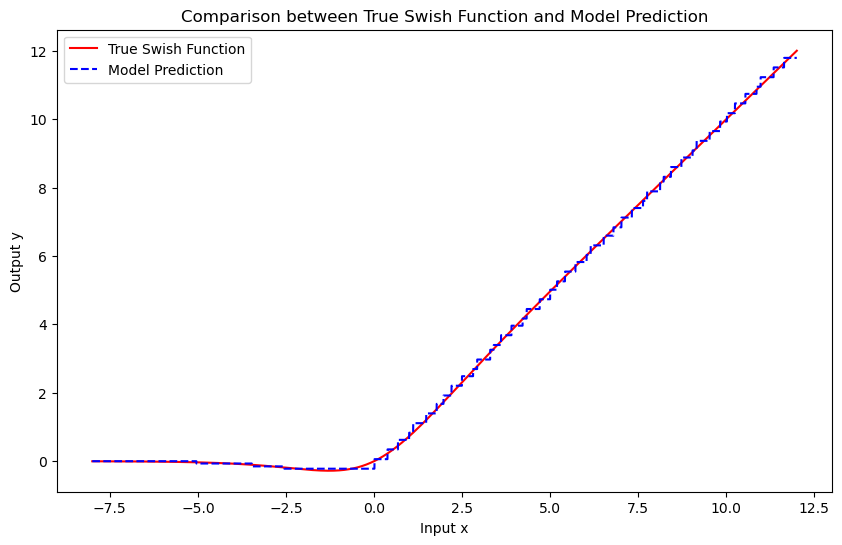

In [105]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -2, steps=20000),
#     torch.linspace(-2, 2, steps=60000),
#     torch.linspace(2, 12, steps=20000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=12

Epoch 1/20000, Loss: 0.997822105884552
Epoch 1001/20000, Loss: 0.06259340047836304
Epoch 2001/20000, Loss: 0.019747143611311913
Epoch 3001/20000, Loss: 0.012219089083373547
Epoch 4001/20000, Loss: 0.008772775530815125
Epoch 5001/20000, Loss: 0.00678221695125103
Epoch 6001/20000, Loss: 0.00484702130779624
Epoch 7001/20000, Loss: 0.004277860280126333
Epoch 8001/20000, Loss: 0.00342313083820045
Epoch 9001/20000, Loss: 0.0027352161705493927
Epoch 10001/20000, Loss: 0.002527667907997966
Epoch 11001/20000, Loss: 0.0022330554202198982
Epoch 12001/20000, Loss: 0.0018348230514675379
Epoch 13001/20000, Loss: 0.0018833819776773453
Epoch 14001/20000, Loss: 0.0019231862388551235
Epoch 15001/20000, Loss: 0.001838258351199329
Epoch 16001/20000, Loss: 0.0018259164644405246
Epoch 17001/20000, Loss: 0.0018393084174022079
Epoch 18001/20000, Loss: 0.0018275832990184426
Epoch 19001/20000, Loss: 0.0018275735201314092
Loss values: [0.997822105884552, 0.14380723237991333, 0.10886955261230469, 0.13222783803939

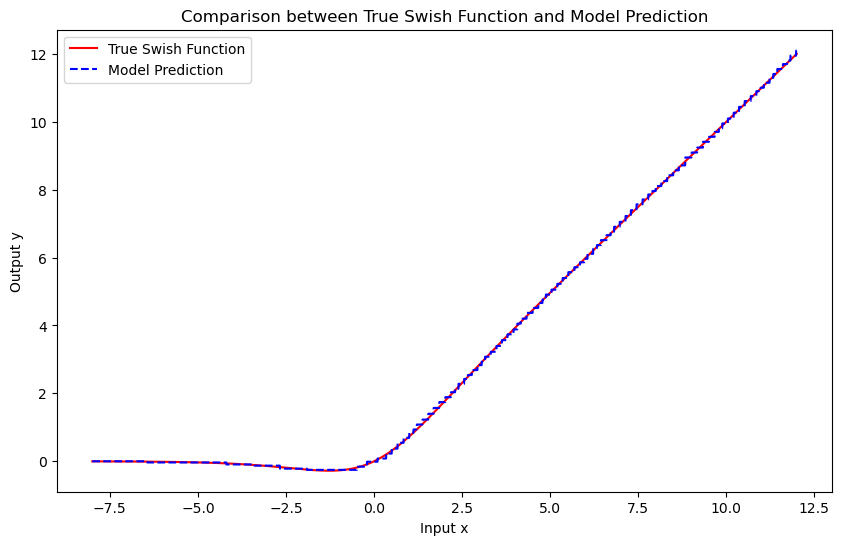

In [106]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -2, steps=20000),
#     torch.linspace(-2, 2, steps=60000),
#     torch.linspace(2, 12, steps=20000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.10544809699058533
Epoch 1001/20000, Loss: 0.012164748273789883
Epoch 2001/20000, Loss: 0.0034148101694881916
Epoch 3001/20000, Loss: 0.0022989625576883554
Epoch 4001/20000, Loss: 0.0017140459967777133
Epoch 5001/20000, Loss: 0.0014002660755068064
Epoch 6001/20000, Loss: 0.0009197897161357105
Epoch 7001/20000, Loss: 0.0009791208431124687
Epoch 8001/20000, Loss: 0.0012460718862712383
Epoch 9001/20000, Loss: 0.0012002793373540044
Epoch 10001/20000, Loss: 0.0015489739598706365
Epoch 11001/20000, Loss: 0.0015063714236021042
Epoch 12001/20000, Loss: 0.0011446685530245304
Epoch 13001/20000, Loss: 0.0009039681171998382
Epoch 14001/20000, Loss: 0.0007550992304459214
Epoch 15001/20000, Loss: 0.0006337311933748424
Epoch 16001/20000, Loss: 0.0005864761769771576
Epoch 17001/20000, Loss: 0.0005695095169357955
Epoch 18001/20000, Loss: 0.0005583572201430798
Epoch 19001/20000, Loss: 0.0005368120037019253
Loss values: [0.10544809699058533, 0.039277832955121994, 0.03450810536742210

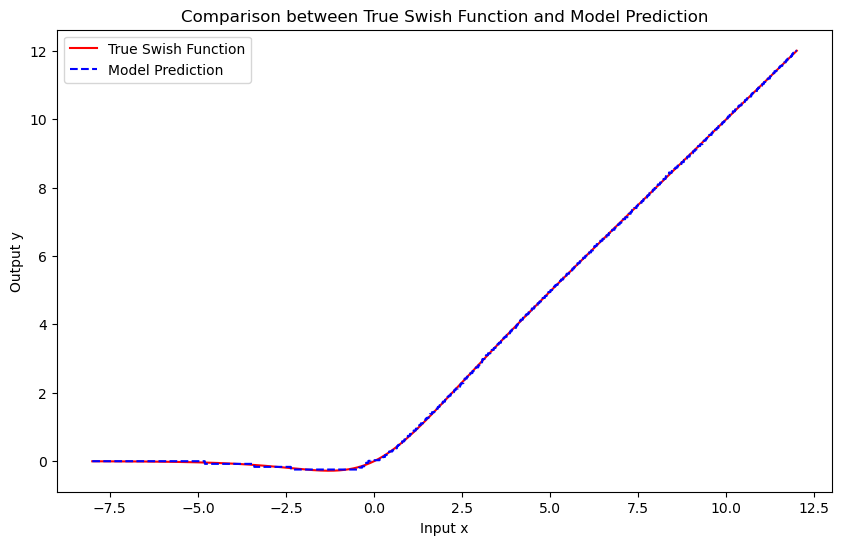

In [107]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -2, steps=20000),
#     torch.linspace(-2, 2, steps=60000),
#     torch.linspace(2, 12, steps=20000)
# )).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()